In [2]:
import torch
from torch import nn #neural network
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import pandas as pd

In [3]:
# Making 1000 samples
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

len(X), len(y)

(1000, 1000)

In [4]:
print(X[:5,0])

[ 0.75424625 -0.75615888 -0.81539193 -0.39373073  0.44220765]


In [5]:
circles = pd.DataFrame({"X1":X[:,0],"X2":X[:,1], "label":y})


circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


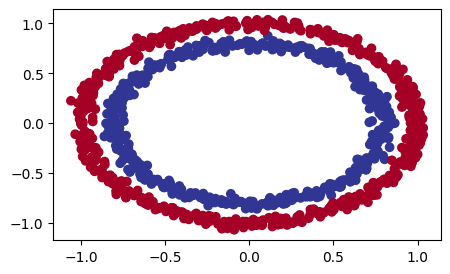

In [6]:
plt.figure(figsize=(5,3))
plt.scatter(x=X[:,0], y = X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [7]:
# Example of feature and label

x_sample = X[0]
y_sample = y[0]
print(f"values for one sample of x : {x_sample}, and for y : {y_sample}")
print(f"shape of sample X : {x_sample.shape}, shape of sample y : {y_sample.shape}")

values for one sample of x : [0.75424625 0.23148074], and for y : 1
shape of sample X : (2,), shape of sample y : ()


In [8]:
X = torch.from_numpy(X).type(torch.float)

y = torch.from_numpy(y).type(torch.float)

X.dtype, y.dtype

(torch.float32, torch.float32)

In [9]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [11]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [12]:
# Setting up device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
# Subclassing nn.Module
class circleModelv0(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=5)
        self.linear2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x:torch.Tensor) ->torch.Tensor :
        return self.linear2(self.linear1(x))

model_0 = circleModelv0().to(device)
model_0

circleModelv0(
  (linear1): Linear(in_features=2, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
next(model_0.parameters()).device

device(type='cpu')

In [15]:
model_0.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.4761,  0.5339],
                      [ 0.1614,  0.3403],
                      [ 0.7050, -0.4528],
                      [-0.6826,  0.1268],
                      [ 0.5581, -0.0351]])),
             ('linear1.bias',
              tensor([ 2.0981e-01,  3.9685e-01, -2.9544e-01, -3.2969e-01,  3.9029e-04])),
             ('linear2.weight',
              tensor([[ 0.0382, -0.2676, -0.0587, -0.0133,  0.3243]])),
             ('linear2.bias', tensor([-0.1917]))])

In [16]:
# Replicating the model above with nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)
model_0


Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
# Make predictions

with torch.inference_mode():
    y_pred = model_0(X_test.to(device))

    print(f"Length of predictions : {len(y_pred)}, shape : {y_pred.shape}")
    print(f"Length of test samples : {len(X_test)}, shape : {X_test.shape}")
    print(f"First 10 predictions : {y_pred[:10]}")
    print(f"First 10 labels : {y[:10]}")

Length of predictions : 200, shape : torch.Size([200, 1])
Length of test samples : 200, shape : torch.Size([200, 2])
First 10 predictions : tensor([[ 0.2055],
        [ 0.2680],
        [-0.1217],
        [ 0.2989],
        [-0.3811],
        [-0.3409],
        [ 0.0406],
        [-0.1027],
        [-0.1103],
        [ 0.2693]])
First 10 labels : tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.])


In [18]:
# Defining a loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [19]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [20]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.2055],
        [ 0.2680],
        [-0.1217],
        [ 0.2989],
        [-0.3811]])

In [21]:
y_pred_probability = torch.sigmoid(y_logits)
y_pred_probability

tensor([[0.5512],
        [0.5666],
        [0.4696],
        [0.5742],
        [0.4059]])

In [22]:
# Find the predicted labels
y_preds = torch.round(y_pred_probability)

y_pred_label = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_label.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 0., 1., 0.])

In [23]:
y_test[:5], y_pred_label[:5].squeeze()

(tensor([1., 0., 1., 0., 1.]),
 tensor([1., 1., 0., 1., 0.], grad_fn=<SqueezeBackward0>))

In [24]:
# Creating training and testing loop

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

epochs = 100
train_loss = []
test_loss = []

for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(X_train.to(device)).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train.to(device)) # nn.BCEWithLogitsLoss

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward() #backpropagation

    optimizer.step() #update weights and biases

    model_0.eval()

    with torch.inference_mode():
        t_logits = model_0(X_test.to(device)).squeeze()
        test_preds = torch.round(torch.sigmoid(t_logits))
        t_loss = loss_fn(t_logits, y_test.to(device))

        t_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

        if epoch%10==0:
            print(f"Epoch : {epoch}, loss : {loss:.5f}, acc : {acc:.2f}%, test loss : {t_loss:.5f}, test accuracy : {t_acc:.2f}%")


Epoch : 0, loss : 0.69939, acc : 49.38%, test loss : 0.70660, test accuracy : 47.00%
Epoch : 10, loss : 0.69775, acc : 50.00%, test loss : 0.70464, test accuracy : 47.50%
Epoch : 20, loss : 0.69672, acc : 50.12%, test loss : 0.70321, test accuracy : 48.00%
Epoch : 30, loss : 0.69600, acc : 50.50%, test loss : 0.70207, test accuracy : 48.50%
Epoch : 40, loss : 0.69545, acc : 50.38%, test loss : 0.70113, test accuracy : 49.00%
Epoch : 50, loss : 0.69502, acc : 50.62%, test loss : 0.70034, test accuracy : 49.00%
Epoch : 60, loss : 0.69467, acc : 50.75%, test loss : 0.69966, test accuracy : 49.50%
Epoch : 70, loss : 0.69439, acc : 50.50%, test loss : 0.69908, test accuracy : 49.50%
Epoch : 80, loss : 0.69415, acc : 50.62%, test loss : 0.69859, test accuracy : 49.00%
Epoch : 90, loss : 0.69396, acc : 50.62%, test loss : 0.69816, test accuracy : 48.50%


In [25]:
# Downloading helper_funtions.py for plotting decision boundary

# import requests
# from pathlib import Path
#
# if Path('helper_funcations.py').is_file():
#     print("The file already exists")
#
# else:
#     print("Downloading helper_funcitons.py")
#     request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
#     with open('helper_functions.py','wb') as f:
#         f.write(request.content)


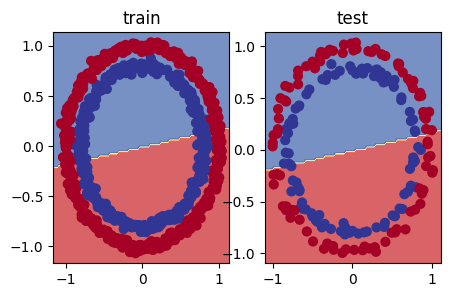

In [26]:
# Plotting decision boundary

from helper_functions import plot_decision_boundary

plt.figure(figsize=(5,3))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_0, X_train, y_train)


plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model_0, X_test, y_test)

In [27]:
# Improving the model

class circleModelv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x:torch.Tensor) ->torch.Tensor :
        return self.layer3(self.layer2(self.layer1(x)))

modelv1 = circleModelv1().to(device)

modelv1

circleModelv1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
loss_fn_1 = nn.BCEWithLogitsLoss()
optimizer_1 = torch.optim.SGD(params=modelv1.parameters(), lr=0.1)

In [29]:
torch.manual_seed(RANDOM_SEED)
epochs = 1000

train_loss = []
test_loss = []

for epoch in range(epochs):
    modelv1.train()
    y_logits = modelv1(X_train.to(device)).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn_1(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    optimizer_1.zero_grad()

    loss.backward()

    optimizer_1.step()

    modelv1.eval()
    with torch.inference_mode():
        test_logits = modelv1(X_test.to(device)).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        t_loss = loss_fn_1(y_logits, y_train)
        t_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

        if epoch%100 == 0:
            print(f"Epoch : {epoch}, loss : {loss}, acc : {acc}%, test loss : {t_loss}, t_acc : {t_acc}%")

Epoch : 0, loss : 0.6939550638198853, acc : 50.875%, test loss : 0.6939550638198853, t_acc : 51.0%
Epoch : 100, loss : 0.6930477619171143, acc : 50.375%, test loss : 0.6930477619171143, t_acc : 48.0%
Epoch : 200, loss : 0.692986011505127, acc : 51.125%, test loss : 0.692986011505127, t_acc : 46.0%
Epoch : 300, loss : 0.6929805278778076, acc : 51.625%, test loss : 0.6929805278778076, t_acc : 45.0%
Epoch : 400, loss : 0.6929798722267151, acc : 51.125%, test loss : 0.6929798722267151, t_acc : 46.0%
Epoch : 500, loss : 0.6929798722267151, acc : 51.0%, test loss : 0.6929798722267151, t_acc : 46.0%
Epoch : 600, loss : 0.6929798722267151, acc : 51.0%, test loss : 0.6929798722267151, t_acc : 46.0%
Epoch : 700, loss : 0.6929798722267151, acc : 51.0%, test loss : 0.6929798722267151, t_acc : 46.0%
Epoch : 800, loss : 0.6929798722267151, acc : 51.0%, test loss : 0.6929798722267151, t_acc : 46.0%
Epoch : 900, loss : 0.6929798126220703, acc : 51.0%, test loss : 0.6929798126220703, t_acc : 46.0%


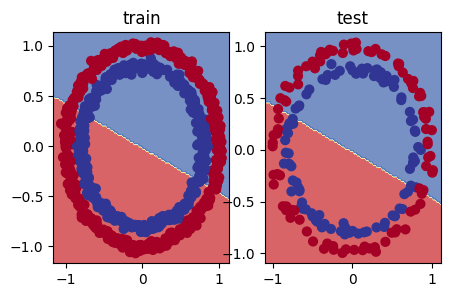

In [30]:
# Plotting the decision boundary

from helper_functions import plot_decision_boundary

plt.figure(figsize=(5,3))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(modelv1, X_train, y_train)


plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(modelv1, X_test, y_test)

In [31]:
# Creating some data to see our model can learn it..

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

X_regression[:5], y_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [32]:
# creating splits

train_split = int(0.8*len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]

X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

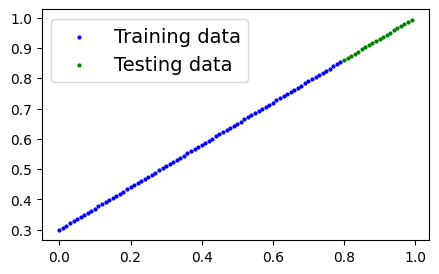

In [33]:
from helper_functions import plot_predictions

plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

In [34]:
# Adjusting the modelv1 to fit the linear model

modelv2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

modelv2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
loss_regression_fn = nn.L1Loss()
optimizer_regression = torch.optim.SGD(params=modelv2.parameters(), lr = 0.01)

In [36]:
epochs = 100

torch.manual_seed(RANDOM_SEED)
for epoch in range(epochs):

    modelv2.train()
    y_pred = modelv2(X_train_regression.to(device))
    loss = loss_regression_fn(y_pred, y_train_regression.to(device))
    optimizer_regression.zero_grad()
    loss.backward()

    optimizer_regression.step()

    modelv2.eval()
    with torch.inference_mode():
        test_pred = modelv2(X_test_regression.to(device))
        test_loss = loss_regression_fn(test_pred, y_test_regression.to(device))

    if epoch%10==0:
        print(f"Epoch : {epoch}, loss : {loss:.5f}, test loss : {test_loss}")

Epoch : 0, loss : 0.75986, test loss : 0.9110288619995117
Epoch : 10, loss : 0.40240, test loss : 0.5047394037246704
Epoch : 20, loss : 0.06007, test loss : 0.10150802135467529
Epoch : 30, loss : 0.01559, test loss : 0.032307326793670654
Epoch : 40, loss : 0.03092, test loss : 0.0011067807208746672
Epoch : 50, loss : 0.03196, test loss : 0.0010761499870568514
Epoch : 60, loss : 0.03192, test loss : 0.0017017603386193514
Epoch : 70, loss : 0.03081, test loss : 0.0009657889604568481
Epoch : 80, loss : 0.03077, test loss : 0.0014975011581555009
Epoch : 90, loss : 0.02967, test loss : 0.0009232640150003135


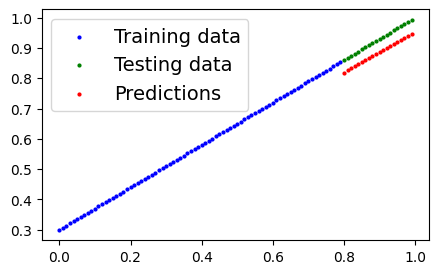

In [37]:
with torch.inference_mode():
    test_pred = modelv2(X_test_regression.to(device))


plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression, predictions=test_pred)

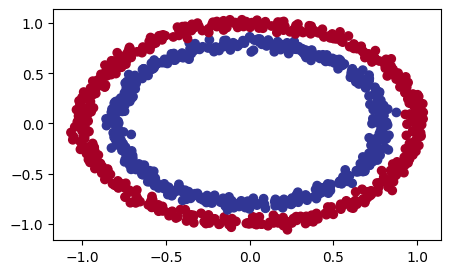

In [38]:
# Adding non-linearity to our model

# Recreating the non-linear data

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

samples = 1000

X_0, y_0 = make_circles(samples, noise = 0.03, random_state=42)

plt.figure(figsize=(5,3))
plt.scatter(X_0[:,1], X_0[:,0], c = y_0, cmap=plt.cm.RdYlBu)


In [39]:
# Creating the split into training and testing set
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X_0).type(torch.float)

y = torch.from_numpy(y_0).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train.shape, X_test.shape

(torch.Size([800, 2]), torch.Size([200, 2]))

In [40]:
# Building the model with non-linear activation functions

from torch import nn # neural network

class circleModelv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # non-linear activation function

    def forward(self, x : torch.Tensor ) -> torch.Tensor :
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

modelv3 = circleModelv2().to(device)
modelv3

circleModelv2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [41]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=modelv3.parameters(), lr = 0.1)

In [42]:
epochs = 2001

for epoch in range(epochs):
    modelv3.train()
    y_logits = modelv3(X_train.to(device)).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train.to(device))
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    modelv3.eval()
    with torch.inference_mode():
        t_logits = modelv3(X_test.to(device)).squeeze()
        t_preds = torch.round(torch.sigmoid(t_logits))
        t_loss = loss_fn(t_logits, y_test.to(device))
        t_acc = accuracy_fn(y_true=y_test, y_pred=t_preds)
    if epoch%100==0:
        print(f"Epoch : {epoch}, loss : {loss}, acc : {acc}%, test loss : {t_loss}, t_acc : {t_acc}%")

Epoch : 0, loss : 0.6929463148117065, acc : 50.0%, test loss : 0.6931881904602051, t_acc : 50.0%
Epoch : 100, loss : 0.691152811050415, acc : 52.87500000000001%, test loss : 0.6910240054130554, t_acc : 52.5%
Epoch : 200, loss : 0.6897743940353394, acc : 53.37499999999999%, test loss : 0.6893961429595947, t_acc : 55.00000000000001%
Epoch : 300, loss : 0.687949538230896, acc : 53.0%, test loss : 0.6872316598892212, t_acc : 56.00000000000001%
Epoch : 400, loss : 0.6851677894592285, acc : 52.75%, test loss : 0.684114933013916, t_acc : 56.49999999999999%
Epoch : 500, loss : 0.6810224652290344, acc : 52.75%, test loss : 0.6794120669364929, t_acc : 56.49999999999999%
Epoch : 600, loss : 0.675148606300354, acc : 54.50000000000001%, test loss : 0.6728507876396179, t_acc : 56.00000000000001%
Epoch : 700, loss : 0.6665886640548706, acc : 58.375%, test loss : 0.6632164716720581, t_acc : 59.0%
Epoch : 800, loss : 0.6515954732894897, acc : 64.0%, test loss : 0.647568941116333, t_acc : 67.5%
Epoch : 

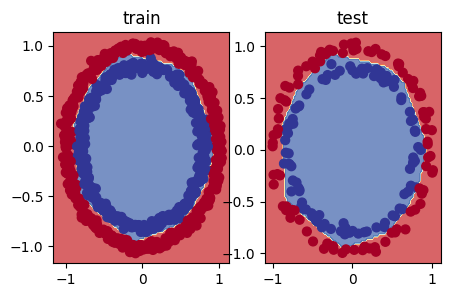

In [43]:
# Plotting the decision boundary

plt.figure(figsize=(5,3))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(modelv3, X_train, y_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(modelv3, X_test, y_test)

In [51]:


modelv3.eval()
with torch.inference_mode():
    test_logits = modelv3(X_test.to(device)).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

print((test_preds==y_test).unique())

tensor([True])
